In [1]:
from collections import defaultdict
from dataclasses import dataclass
import io
import json
from pathlib import Path
import os
import torchio as tio
from typing import Literal
from matplotlib import pyplot as plt
import random
import numpy as np
from scipy import ndimage
from seaborn import color_palette
from skimage.util import random_noise
from skimage.transform import resize
import cv2
from PIL import Image

import nibabel as nib
from nilearn.image import new_img_like, resample_img
from nilearn.plotting import plot_anat, view_img
from niworkflows.viz.utils import cuts_from_bbox, robust_set_limits
from niworkflows.utils.images import rotation2canonical, rotate_affine

from halfpipe.utils.path import split_ext

220902-11:35:46,990 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.8.3


In [2]:
%matplotlib inline

In [3]:
base_directory = Path("/mnt/mbServerData/newdata/moods/halfpipe/bonn")
#Path("/Users/dominik/Downloads/usable")
#Path("/mnt/mbServerData/newdata/moods/halfpipe/bonn")

In [4]:
exclude_files = list(base_directory.glob("exclude*.json"))
exclude_entries = list()

for exclude_file in exclude_files:
    with open(exclude_file) as file_handle:
        exclude_entries.extend(json.load(file_handle))

In [5]:
paths_by_tags = defaultdict(lambda: defaultdict(set))
tags_by_paths = dict()

bids_directory = base_directory / "derivatives" / "fmriprep"
for bids_path in bids_directory.glob("**/*"):
    stem, extension = split_ext(bids_path)

    if stem.startswith("."):
        continue  # skip hidden files

    tokens = stem.split("_")

    tags = dict(
        path=str(bids_directory), 
        suffix=tokens.pop(-1),
        extension=extension,
    )
    tags_by_paths[bids_path] = tags

    for token in tokens:
        key, value = token.split("-")
        tags[key] = value
    for key, value in tags.items():
        paths_by_tags[key][value].add(bids_path)

In [6]:
def get(**filters):
    res = None
    
    for key, value in filters.items():
        if key not in paths_by_tags:
            # logger.info(f"Unknown key \"{key}\"")        
            return None
    
        values = paths_by_tags[key]
        if value is None:
            for paths in values.values():
                res -= paths
            continue
                
        elif value not in values:
            # logger.info(f"Unknown value \"{value}\"")        
            return None
        
        paths = values[value]
        if res is not None:
            res &= paths
        else:
            res = paths.copy()
    
    return res

def get_tag_value(path, key):
    return tags_by_paths[path].get(key)

In [7]:
def _plot_anat_with_contours(image, segs=None, **plot_params):
    nsegs = len(segs or [])
    plot_params = plot_params or {}
    # plot_params' values can be None, however they MUST NOT
    # be None for colors and levels from this point on.
    colors = plot_params.pop("colors", None) or []
    levels = plot_params.pop("levels", None) or []
    missing = nsegs - len(colors)
    if missing > 0:  # missing may be negative
        colors = colors + color_palette("husl", missing)

    colors = [[c] if not isinstance(c, list) else c for c in colors]

    if not levels:
        levels = [[0.5]] * nsegs

    # anatomical
    display = plot_anat(image, **plot_params)

    # remove plot_anat -specific parameters
    plot_params.pop("display_mode")
    plot_params.pop("cut_coords")

    plot_params["linewidths"] = 0.5
    for i in reversed(range(nsegs)):
        plot_params["colors"] = colors[i]
        display.add_contours(segs[i], levels=levels[i], **plot_params)
        
    return display

In [8]:
target_width = 2048

def to_rgb(display):
    figure = display.frame_axes.figure
    canvas = figure.canvas
    
    # scale to target_width
    width, height = canvas.get_width_height()
    figure.set_dpi(target_width / width * figure.get_dpi())
    
    canvas.draw()
    width, height = canvas.get_width_height()
    
    image = np.frombuffer(
        canvas.tostring_rgb(), dtype=np.uint8
    ).reshape((height, width, -1))[..., :3]
    
    image = image[:, :target_width, :]  # crop rounding errors
    
    return image

In [9]:
@dataclass
class SkullStrip:
    t1w: nib.Nifti1Image
    mask: nib.Nifti1Image
    label: Literal["usable", "unusable"]
    def to_image(self):
        plot_params = dict(colors=None)

        image_nii: nib.Nifti1Image = self.t1w
        seg_nii = self.mask

        canonical_r = rotation2canonical(image_nii)
        image_nii = rotate_affine(image_nii, rot=canonical_r)
        seg_nii = rotate_affine(seg_nii, rot=canonical_r)

        data = image_nii.get_fdata()
        plot_params = robust_set_limits(data, plot_params)

        bbox_nii = seg_nii

        cuts = cuts_from_bbox(bbox_nii, cuts=7)

        images = list()
        for d in plot_params.pop("dimensions", ("z", "x", "y")):
            plot_params["display_mode"] = d
            plot_params["cut_coords"] = cuts[d]
            display = _plot_anat_with_contours(
                image_nii, segs=[seg_nii], **plot_params
            )
            images.append(to_rgb(display))
            display.close()

        image = np.vstack(images)
        return image

In [10]:
skull_strips = list()

for exclude_entry in exclude_entries:
    rating = exclude_entry["rating"]
    type = exclude_entry["type"]
    sub = exclude_entry["sub"]
    
    if rating != "good":
        continue
        
    if type != "skull_strip_report":
        continue
        
    t1w_files = get(sub=sub, desc="preproc", res=None, suffix="T1w", extension=".nii.gz")
    if t1w_files is None:
        continue
    (t1w_file,) = t1w_files
    
    mask_files = get(sub=sub, desc="brain", res=None, suffix="mask", extension=".nii.gz")
    if mask_files is None:
        continue
    (mask_file,) = mask_files   
        
    skull_strips.append(
        SkullStrip(
            t1w=nib.load(t1w_file),
            mask=nib.load(mask_file),
        )
    )

### Nifti2Numpy

In [11]:
class NiftiToNumpy():
    def __call__(self,file):
        a = nib.load(file)
        a = nib.as_closest_canonical(a) # transform into RAS as proposed in nibabel documentation
        a = np.array(a.dataobj)
        a = np.float32(a)
        return a

## Augmentation Strategies functions

### Random Rotate Mask

In [12]:
def randomRotateMask(skullstrip: SkullStrip, max_angle: int):
    angle = random.uniform(-max_angle, max_angle)
    
    mask = skullstrip.mask
    mask_data = np.asanyarray(mask.dataobj).astype(bool)
    
    bad_mask_data = ndimage.rotate(mask_data, angle, reshape=False, axes=(0,1), output=float) > 0.5
    if not mask_data.shape == bad_mask_data.shape:
        return None
    bad_mask = new_img_like(mask, bad_mask_data, copy_header=True)
    skullstrip.mask = bad_mask
    
    new_skullstrip = skullstrip # save as variable to return as file if necessary
    # Show images
    #plot_anat(bad_mask)
    #image = new_skullstrip.to_image()
    #figure = plt.figure(figsize=(20,10))
    #plt.imshow(image)
    #print(angle)
    return new_skullstrip

### Random Flipping

In [13]:
def randomSkullFlip(t1w_file: Path, mask_file: Path):
    testskull = SkullStrip(t1w=nib.load(t1w_file), mask=nib.load(mask_file))
    a = NiftiToNumpy()
    b = a(t1w_file)
    #t1w = skullstrip.t1w
    #t1w_data = nib.as_closest_canonical(t1w)
    #t1w_data = np.array(t1w_data.dataobj).astype(np.float32)
    #plot_anat(nib.load(t1w_file))
    flipped_data = np.fliplr(b) # can change to ud and maybe on different axis (0,1)(1,2)(0,2)
    
    nifti_mask = nib.load(mask_file)
    ref_affine = nifti_mask.affine
    new_t1w = nib.Nifti1Image(flipped_data, affine=ref_affine)
    testskull.t1w = new_t1w
    return testskull
    #new_image = testskull.to_image()
    #figure = plt.figure(figsize=(20,10))
    #plt.imshow(new_image)

### Increase Contrast

In [14]:
def increaseContrast(skullstrip: SkullStrip):
    t1w = skullstrip.t1w
    #plot_anat(t1w)
    t1w_data = np.asanyarray(t1w.dataobj)
    
    minval = np.percentile(t1w_data, 2)
    maxval = np.percentile(t1w_data, 98)
    pixvals = np.clip(t1w_data, minval, maxval)
    pixvals = ((pixvals - minval) / (maxval - minval)) * 255
    new_t1w = new_img_like(t1w, pixvals, copy_header=True)
    skullstrip.t1w = new_t1w
    new_skullstrip = skullstrip # save as variable to return as file if necessary
    #plot_anat(new_t1w)
    #image = new_skullstrip.to_image()
    #figure = plt.figure(figsize=(20,10))
    #plt.imshow(image)
    return new_skullstrip

### Random Noise


In [15]:
def randomNoise(skullstrip: SkullStrip):
    t1w = skullstrip.t1w
    #plot_anat(t1w)
    t1w_data = np.asanyarray(t1w.dataobj).astype(np.uint8) # because gaussian noise adds a np.uint8 mask to the img
    
    noise_t1w_data = random_noise(t1w_data, mode='gaussian', var=0.01**2)
    noise_img = (255*noise_t1w_data).astype(np.uint8)

    noise_t1w = new_img_like(t1w, noise_img, copy_header=True)
    
    # skullstrip.t1w = noise_t1w
    # new_skullstrip = skullstrip # save as variable to return as file if necessary
    new_skullstrip = SkullStrip(t1w=noise_t1w, mask=skullstrip.mask)
    #plot_anat(noise_t1w)
    #image = new_skullstrip.to_image()
    #figure = plt.figure(figsize=(20,10))
    #plt.imshow(image)
    return new_skullstrip

### Remove text and axis from nifti Image (not working yet!)

In [16]:
def removeUnnecessaryText(skullstrip: SkullStrip):
    t1w = skullstrip.t1w
    plot_anat(t1w)
    t1w_data = np.asanyarray(t1w.dataobj).astype(np.uint8)
    print(t1w_data.shape)
    
    # coeffs = np.array([0.114, 0.587, 0.229])
    # image_gray = (t1w_data.astype(np.float) * coeffs).sum(axis=-1)
    # image_gray = image_gray.astype(t1w_data.dtype)
    #t1w_data = t1w_data[:,:,0]
    #grayscale_img = cv2.cvtColor(t1w_data, cv2.COLOR_BGR2GRAY)
    mask = cv2.threshold(t1w_data, 210, 255, cv2.THRESH_BINARY)[1][:,:,0]
    #mask2 = cv2.threshold(t1w_data, 210, 255, cv2.THRESH_BINARY)
    print(mask.dtype)
    #print(mask2.shape)
    #mask = np.uint8(mask)
    dst = cv2.inpaint(t1w_data[:,:,0], mask, 3, cv2.INPAINT_NS)
    print(dst.shape)
    np.expand_dims(dst, axis=2)
    print(dst.shape)
    #dst.shape = t1w_data.shape
    dst.shape = np.dstack((dst, t1w_data)).shape
    print(dst)
    new_t1w = new_img_like(t1w, dst, copy_header=True)
    skullstrip.t1w = new_t1w
    new_skullstrip = skullstrip # save as variable to return as file if necessary
    plot_anat(new_t1w)

## Load usable files


### Load one test skullstrip

In [17]:
t1wpath = "/Users/dominik/Downloads/usable/ds-integrament_site-berlin_sub-PIABR9GGF_desc-preproc_T1w.nii.gz"
maskpath = "/Users/dominik/Downloads/usable/ds-integrament_site-berlin_sub-PIABR9GGF_desc-brain_mask.nii.gz"
test_skullstrip = SkullStrip(t1w=nib.load(t1wpath),
                              mask=nib.load(maskpath),
                            label="usable")

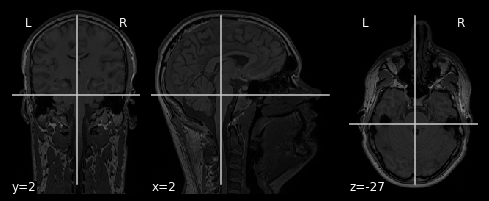

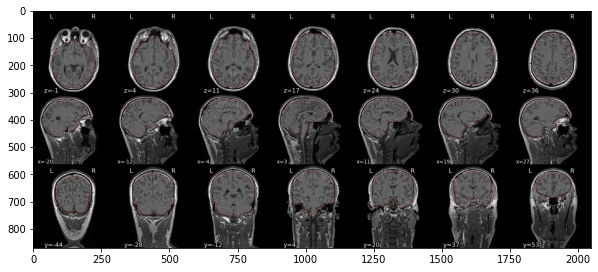

In [18]:
plot_anat(test_skullstrip.t1w)

image = test_skullstrip.to_image()
figure = plt.figure(figsize=(10,20))
plt.imshow(image)

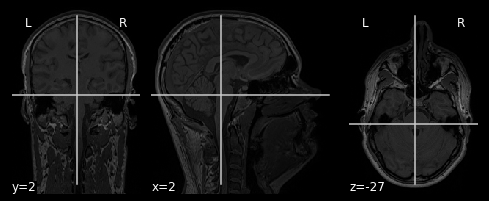

In [19]:
add_noise = tio.RandomNoise()
noisy_img = add_noise(nib.load(t1wpath))
plot_anat(noisy_img)

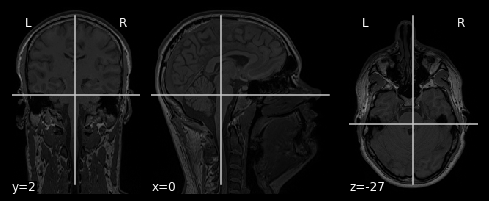

In [20]:
rand_flip = tio.RandomFlip("L",flip_probability=1)
flipped_img = rand_flip(nib.load(t1wpath))
plot_anat(flipped_img)

In [31]:
spatial = tio.OneOf({
        tio.RandomAffine(): 0.8,
        tio.RandomElasticDeformation(): 0.2,
    },
)

rand_motion = tio.RandomMotion()

In [21]:
motion_img = rand_motion(nib.load(t1wpath))
plot_anat(motion_img)
motionskll = SkullStrip(t1w=motion_img,
                       mask=nib.load(maskpath),
                       label="usable",)
motions = motionskll.to_image()
figure = plt.figure(figsize=(20,10))
print(motions.shape)
plt.imshow(motions)

NameError: name 'rand_motion' is not defined

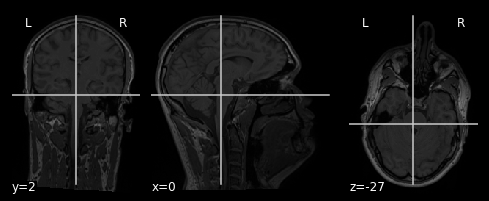

In [30]:
new_img = spatial(nib.load(t1wpath))
plot_anat(new_img)

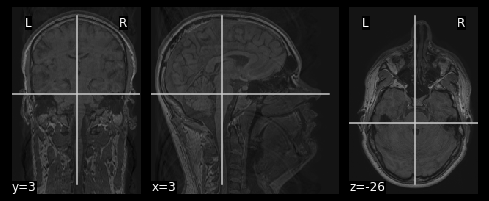

In [36]:
rand_ghosting = tio.RandomGhosting()
ghost_img = rand_ghosting(nib.load(t1wpath))
plot_anat(ghost_img)

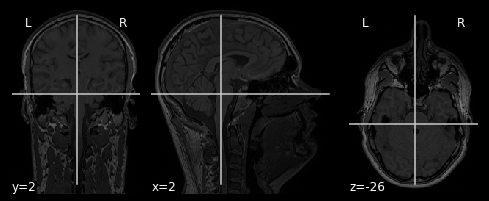

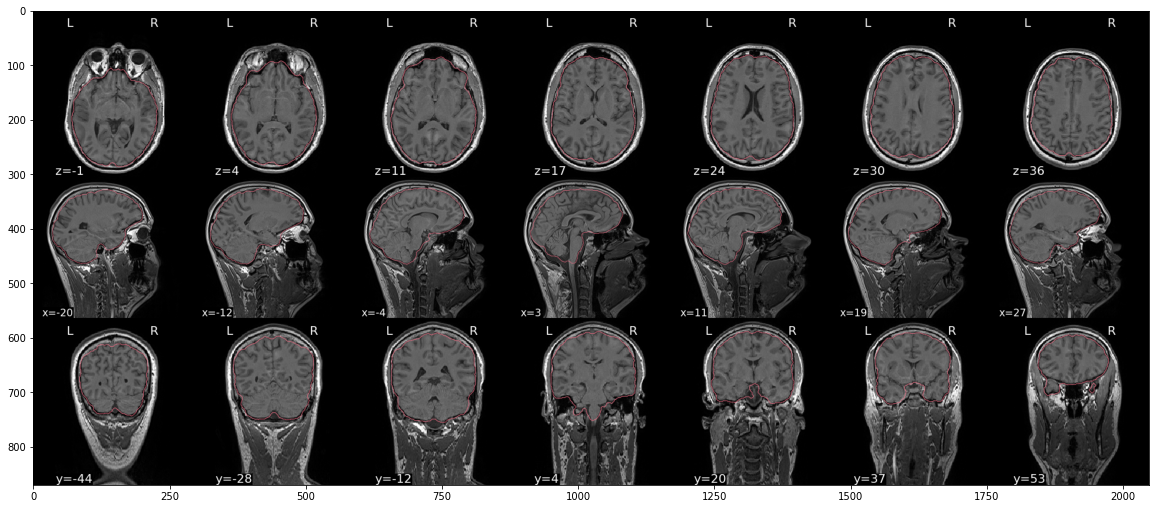

In [58]:
rand_aff = tio.ZNormalization()
aff_img = rand_aff(nib.load(t1wpath))
plot_anat(aff_img)
affskll = SkullStrip(t1w=aff_img,
                    mask=nib.load(maskpath),
                    label="unusable",)
affins = affskll.to_image()
figure = plt.figure(figsize=(20,10))
plt.imshow(affins)

(870, 2048, 3)


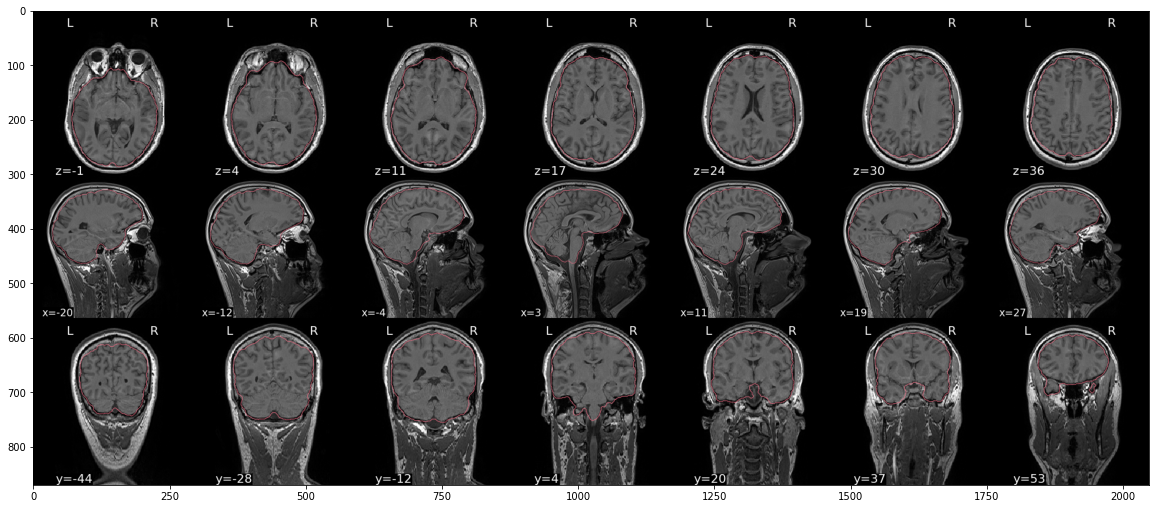

In [22]:
test_skullstrip = SkullStrip(t1w=nib.load(t1wpath),
                              mask=nib.load(maskpath),
                            label="usable")
normal = test_skullstrip.to_image()
figure = plt.figure(figsize=(20,10))
print(normal.shape)
plt.imshow(normal)

In [24]:
# show images
#nifti_img = nib.load(t1wpath)
#nifti_img = nib.as_closest_canonical(nifti_img)
#nii_data = nifti_img.get_fdata()
#nii_aff = nifti_img.affine
#nii_hdr = nifti_img.header
#print(nii_aff, "\n", nii_hdr)
#print(nii_data.shape)
#for slice_Number in range(nii_data.shape[2]):
#    plt.imshow(nii_data[:,:,slice_Number])
#    plt.show()

## Load complete datafolder

In [26]:
root_dir = "/Users/dominik/Downloads/usable"